# Breakdown DEM
This notebook uses the clipped DEM to derive topographical statistics per plot.

We want to open the DEM file in meters of elevation, so we can calculate statistics.

In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dem_path = '../data/DEM/RegressionRidge_DEM.tif'
dem_utm_path = '../data/DEM/RegressionRidge_DEM_utm.tif'  

# Reproject DEM to UTM (meters)
with rasterio.open(dem_path) as src:
    if src.crs.to_epsg() != 32610:  #
        dst_crs = 'EPSG:32610'
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        
        # save a copy of projection for later loading
        with rasterio.open(dem_utm_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.bilinear
                )
        dem_file = dem_utm_path
    else:
        dem_file = dem_path

In [2]:
# Load DEM
with rasterio.open(dem_file) as src:
    dem = src.read(1)   
    transform = src.transform
    nodata = src.nodata
    xres = transform.a
    yres = transform.e

In [3]:
import numpy as np

# mask nodata
dem = np.where(dem == nodata, np.nan, dem)

In [4]:
# compute slope and aspect
dy, dx = np.gradient(dem, abs(yres), abs(xres))

dxx, dxy = np.gradient(dx, abs(yres), abs(xres))
dyx, dyy = np.gradient(dy, abs(yres), abs(xres)) 

curvature = dxx + dyy 
profile_curv = (
    (dxx * dx**2 + 2 * dxy * dx * dy + dyy * dy**2)
    / ((dx**2 + dy**2) * (1 + dx**2 + dy**2)**1.5 + 1e-9)
)

plan_curv = (
    (dxx * dy**2 - 2 * dxy * dx * dy + dyy * dx**2)
    / ((dx**2 + dy**2) * (1 + dx**2 + dy**2)**0.5 + 1e-9)
)

# slope in degrees
slope_deg = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))

# aspect in degrees, 0 = north
aspect_rad = np.arctan2(-dx, dy)
aspect_deg = (np.degrees(aspect_rad) + 360) % 360

# elevation deviation
elev_dev = dem - np.nanmean(dem)

/home/simonhans/anaconda3/envs/GrapeExpectations/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in remainder


Now that we have these statistics calculated for our dem, we can apply our polygons and get plot-wide statistics.

First load polygons. Then use rasterstats zonal stats applied to different vineyard-wide computed topographies.

In [5]:
import geopandas as gpd
import pandas as pd
vineyard_path = '../data/polygons/RegressionRidge.geojson'
# plots_path = '../data/polygons/RegressionRidge_smol.geojson'
plots_path = '../data/polygons/RegressionRidge_smol_smol.pkl'

# Load vineyard polygons
vineyard = gpd.read_file(vineyard_path)
vineyard = vineyard.to_crs(crs=rasterio.open(dem_file).crs)
# vineyard.plot()

# Load plot polygons
plots = pd.read_pickle(plots_path)
plots = plots.to_crs(crs=rasterio.open(dem_file).crs)
# plots.plot()

/home/simonhans/anaconda3/envs/GrapeExpectations/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [6]:
from rasterstats import zonal_stats
import pandas as pd


def calculate_elevation_statistics(gdf):
    # Compute zonal stats
    slope_stats = zonal_stats(gdf, slope_deg, affine=transform, nodata=np.nan,
                              stats=['mean', 'min', 'max'])
    aspect_stats = zonal_stats(gdf, aspect_deg, affine=transform, nodata=np.nan,
                               stats=['mean', 'min', 'max'])
    
    elev_stats = zonal_stats(gdf, dem, affine=transform, nodata=np.nan,
                             stats=['mean', 'min', 'max'])
    
    elev_dev_stats = zonal_stats(gdf, elev_dev, affine=transform, nodata=np.nan,
                             stats=['mean', 'min', 'max'])
    
    curv_stats = zonal_stats(gdf, curvature, affine=transform, nodata=np.nan,
                         stats=['mean', 'min', 'max'])
    
    profile_curv_stats = zonal_stats(gdf, profile_curv, affine=transform, nodata=np.nan,
                         stats=['mean', 'min', 'max'])

    
    plan_curv_stats = curv_stats = zonal_stats(gdf, plan_curv, affine=transform, nodata=np.nan,
                         stats=['mean', 'min', 'max'])


    # Combine into dataframe
    df_features = pd.DataFrame({
        'plot_id': [s for s in gdf['plot_id'].values],
        'slope_mean': [s['mean'] for s in slope_stats],
        'slope_min': [s['min'] for s in slope_stats],
        'slope_max': [s['max'] for s in slope_stats],
        
        'curve_mean': [s['mean'] for s in curv_stats],
        'curve_min': [s['min'] for s in curv_stats],
        'curve_max': [s['max'] for s in curv_stats],
        
        'pro_curve_mean': [s['mean'] for s in profile_curv_stats],
        'pro_curve_min': [s['min'] for s in profile_curv_stats],
        'pro_curve_max': [s['max'] for s in profile_curv_stats],
        
        'plan_curve_mean': [s['mean'] for s in plan_curv_stats],
        'plan_curve_min': [s['min'] for s in plan_curv_stats],
        'plan_curve_max': [s['max'] for s in plan_curv_stats],
        
        
        'aspect_mean': [s['mean'] for s in aspect_stats],
        'aspect_min': [s['min'] for s in aspect_stats],
        'aspect_max': [s['max'] for s in aspect_stats],
        'elev_min': [s['min'] for s in elev_stats],
        'elev_max': [s['max'] for s in elev_stats],
        'elev_mean': [s['mean'] for s in elev_stats],
        'elev_dev_min': [s['min'] for s in elev_dev_stats],
        'elev_dev_max': [s['max'] for s in elev_dev_stats],
        'elev_dev_mean': [s['mean'] for s in elev_dev_stats]
    })

    df_features = df_features.merge(gdf, how = 'inner', on = 'plot_id')
    df_features['total_relief'] = df_features['elev_max'] - df_features['elev_min']

    gdf_features = gpd.GeoDataFrame(df_features, geometry=gdf.geometry, crs=gdf.crs)
    return gdf_features


plot_features = calculate_elevation_statistics(plots)

In [7]:
gdf_features = gpd.GeoDataFrame(
    plot_features,
    geometry=plot_features['geometry'], 
    crs=rasterio.open(dem_file).crs
)

In [8]:
# compute area in square meters
gdf_features['area_m2'] = gdf_features.geometry.area

# convert to hectares -- commonly used in agg
gdf_features['area_ha'] = gdf_features['area_m2'] / 10000

Now to visualize our work!

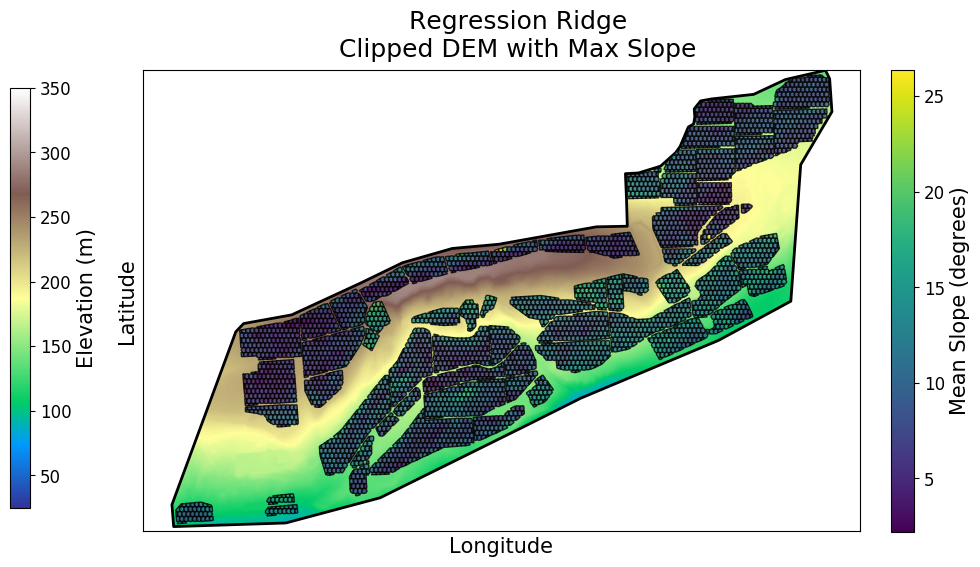

In [9]:
import matplotlib.pyplot as plt

with rasterio.open(dem_file) as src:
    dem = src.read(1, masked=True)
    raster_crs = src.crs
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    

fig, ax = plt.subplots(figsize=(10, 6))

# DEM
im = ax.imshow(
    dem,
    extent=extent,
    origin='upper',
    cmap='terrain',
    vmin=25,
    vmax=350
)

# create a new axes for the left colorbar [left, bottom, width, height]
cbar_ax_left = fig.add_axes([-0.008, 0.15, 0.02, 0.7])  # tweak numbers as needed
cbar_dem = fig.colorbar(im, cax=cbar_ax_left)
cbar_dem.set_label('Elevation (m)', fontsize=15)
cbar_dem.ax.tick_params(labelsize=12)

# vineyard
vineyard.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=2)

# plot features without legend
gdf_features = gdf_features.copy()
gdf_features.plot(
    ax=ax,
    column='slope_max',
    cmap='viridis',
    legend=False,
    alpha=0.8,
    edgecolor='black',
    # linewidth=0.5
)

# slope colorbar on the right (default)
sm = plt.cm.ScalarMappable(
    cmap='viridis',
    norm=plt.Normalize(vmin=plot_features['slope_max'].min(),
                       vmax=plot_features['slope_max'].max())
)
sm._A = []
cbar_aspect = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.04)
cbar_aspect.set_label('Mean Slope (degrees)', fontsize=15)
cbar_aspect.ax.tick_params(labelsize=12)

fig.suptitle('Regression Ridge\nClipped DEM with Max Slope', fontsize = 18)
ax.set_xlabel('Longitude', fontsize = 15)
ax.set_ylabel('Latitude', fontsize = 15)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('../img/dem_w_slope.png')
plt.show()


Save our plot topography features to a pickle for later use.

In [10]:
plot_features = plot_features.to_crs(4326)

In [11]:
plot_features.to_pickle('../data/plot_elev_features.pkl')